In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [2]:
csv_file = "./data/CaseI-Attacks without any change.csv"

In [3]:
df = pd.read_csv(csv_file)
df = df.set_index('Label').fillna(0)

In [4]:
groups = df.groupby(df.index, sort=False)
group_normal = groups.get_group('Normal')

In [5]:
data_normal = torch.from_numpy(group_normal.values).permute(1, 0).unsqueeze(2).float()
data_normal.shape

torch.Size([33, 2045, 1])

In [6]:
def generate_synthetic_data(normal_data, seasonal_freqs, arima_order, trend_degree):
    batch_size, seq_len, _ = normal_data.shape
    t = np.arange(seq_len)

    synthetic_data = np.zeros_like(normal_data)

    for i in range(batch_size):
        # Extract single sequence from the batch
        single_sequence = normal_data[i, :, 0]

        # Seasonal component
        seasonal_component = sum(np.sin(2 * np.pi * t / freq) for freq in seasonal_freqs)

        # Stochastic component
        single_sequence_np = single_sequence.cpu().detach().numpy()  # Convert to NumPy array
        model = ARIMA(single_sequence_np, order=arima_order)
        stochastic_component = model.fit().resid

        # Trend component
        trend_component = np.polyval(np.polyfit(t, single_sequence, trend_degree), t)

        # Combine components
        synthetic_sequence = single_sequence + seasonal_component + stochastic_component + trend_component

        # Store the synthetic sequence back in the synthetic_data array
        synthetic_data[i, :, 0] = synthetic_sequence

    return torch.tensor(synthetic_data).float()

In [7]:
normal_before_RE = np.sin(np.linspace(0, 20, 1000)).reshape(4, -1, 1)  # Example single sequence reshaped to [1, seq_len, 1]
normal_before_RE.shape

(4, 250, 1)

In [8]:
seasonal_freqs = [24, 365]  # Daily and yearly cycles
arima_order = (5, 1, 0)  # ARIMA model order
trend_degree = 2  # Polynomial trend degree

In [9]:
synthetic_data = generate_synthetic_data(data_normal, seasonal_freqs, arima_order, trend_degree)


c:\Users\pc\anaconda3\envs\GAN\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pc\anaconda3\envs\GAN\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


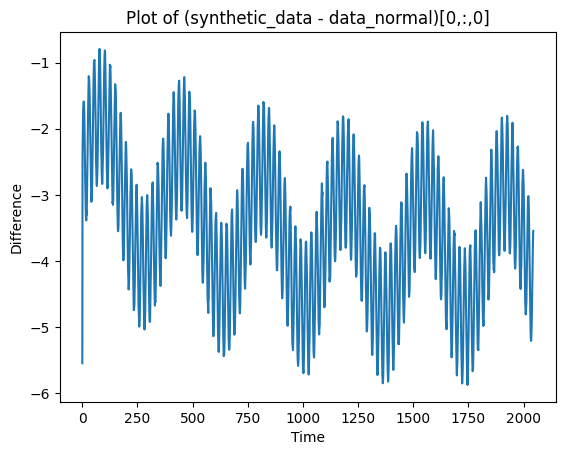

In [10]:
synthetic_data - data_normal
import matplotlib.pyplot as plt

plt.plot((synthetic_data - data_normal)[0,:,0])
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Plot of (synthetic_data - data_normal)[0,:,0]')
plt.show()